In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import *
import requests
from tqdm import tqdm

# Class

## Class itinerary

In [2]:
class Itinerary:
    def __init__(self,stations=np.ndarray,lines=np.ndarray[int]):
        self.starting_station = stations[0]
        self.ending_station = stations[-1]
        self.inter_station = stations[1:-1]
        self.lines = lines
    
    def __str__(self) -> str:
        return self.__repr__()

    def __repr__(self) -> str:
        res = "Itinerary from "+self.starting_station+" to "+self.ending_station
        dep_stations = np.concatenate([[self.starting_station],self.inter_station])
        arr_stations = np.concatenate([self.inter_station,[self.ending_station]])
        for dep_station,end_station,line in zip(dep_stations,arr_stations,self.lines):
            res = res+"\n-"+dep_station+" to "+end_station+" with line(s) "+", ".join(line.astype(str))
        return res

## Class Itinerary_time

In [3]:
class Itinerary_time:
    def __init__(self,stations:np.ndarray,lines:np.ndarray[int], departure_times:np.ndarray, arrival_times:np.ndarray, transition_times:np.ndarray):
        self.departure_stations = stations[:-1]
        self.arrival_stations = stations[1:]
        self.starting_station = stations[0]
        self.ending_station = stations[-1]
        self.inter_station = stations[1:-1]
        self.lines = lines
        self.departure_times = departure_times
        self.arrival_times = arrival_times
        self.transition_times = transition_times
        self.delays = False
        self.delay_50 = np.nan
        self.delay_90 = np.nan
        self.delay_95 = np.nan
        self.probability = np.nan
        self.initial_walk = 0
        self.final_walk = 0
    
    def __str__(self) -> str:
        return self.__repr__()

    def __repr__(self) -> str:
        res = "Itinerary from "+self.starting_station+" to "+self.ending_station+"\nDeparture Time :"+(self.departure_times[0]).strftime("%H:%M:%S")+"\tArrival Time :"+(self.arrival_times[-1]).strftime("%H:%M:%S")
        if(self.delays):
            res+="\nProbability of success: "+str(self.probability)
            res+="\nQuantile 50: "+str(self.arrival_times[-1]+timedelta(seconds=int(self.delay_50)))[11:]
            res+="\nQuantile 90: "+str(self.arrival_times[-1]+timedelta(seconds=int(self.delay_90)))[11:]
            res+="\nQuantile 95: "+str(self.arrival_times[-1]+timedelta(seconds=int(self.delay_95)))[11:]
        for i in range(len(self.lines)-1):
            res = res+"\n\t-In "+self.departure_stations[i]+", take line "+str(self.lines[i])+" at "+self.departure_times[i].strftime("%H:%M:%S")+" to "+self.arrival_stations[i]+" (arriving at "+self.arrival_times[i].strftime("%H:%M:%S")+")"
            wait_time = (self.departure_times[i+1]-self.arrival_times[i]-timedelta(minutes=self.transition_times[i])).seconds
            res = res+"\n\t-Walk "+str(self.transition_times[i])+" minutes and wait "+str(wait_time//60)+"min"+str(wait_time%60)
        res = res+"\n\t-In "+self.departure_stations[-1]+", take line "+str(self.lines[-1])+" at "+self.departure_times[-1].strftime("%H:%M:%S")+" to "+self.arrival_stations[-1]+" (arriving at "+self.arrival_times[-1].strftime("%H:%M:%S")+")"
        return res
    
    def __eq__(self, __value: object) -> bool:
        if(isinstance(__value,Itinerary_time)):
            res = (len(self.departure_stations)==len(__value.arrival_stations))
            if (res):
                for i in range(len(self.departure_times)):
                    res = res&(self.departure_stations[i]==__value.departure_stations[i])
                    res = res&(self.arrival_stations[i]==__value.arrival_stations[i])
                    res = res&(self.departure_times[i]==__value.departure_times[i])
                    res = res&(self.lines[i]==__value.lines[i])
                return res
        return False
    
def sort_itinerary(list_itinerary_non_sorted: np.ndarray[Itinerary_time]):
    order = np.argsort([itin.departure_times[0] for itin in list_itinerary_non_sorted],)
    list_itinerary_non_sorted = list_itinerary_non_sorted[order[::-1]]
    order = np.argsort([itin.arrival_times[-1] for itin in list_itinerary_non_sorted])
    return list_itinerary_non_sorted[order]

def drop_duplicates(list_itinerary_non_sorted: np.ndarray[Itinerary_time]):
    order = np.argsort([itin.arrival_times[-1] for itin in list_itinerary_non_sorted])
    list_itinerary_sorted = list_itinerary_non_sorted[order]
    idx = np.arange(len(order),dtype=int)
    for i in range(len(order)-1):
        if(list_itinerary_sorted[i]==list_itinerary_sorted[i+1]):
            idx[i+1] = idx[i]
    idx = np.sort(np.unique(idx))
    return list_itinerary_sorted[idx]

# Import data

## Functions to prepare data

In [4]:
def transform_to_datetime(x: str):
    if(int(x[:2])>23):
        hour = int(x[:2]) - 24
        return datetime.strptime(str(hour)+x[2:],'%H:%M:%S')
    else:
        return datetime.strptime(x,'%H:%M:%S')
    
def transform_sl_to_datetime(x: str):
    return datetime.strptime(x[11:19],'%H:%M:%S')

def get_datetime(hour: int, min: int, sec: int=0):
    return datetime(1900,1,1,hour,min,sec)

def transform_text_to_list_datetime(x : str):
    x = x.replace(" ","").replace("datetime.datetime","")
    res = []
    i=1
    while (i<len(x)-1):
        letter = x[i]
        if(letter=='('):
            temp = x[i+1:].split(")")[0]
            time_val =temp.split(',')
            time_val.append('0')
            time_val = np.array(time_val).astype(int)
            time_val = get_datetime(time_val[3],time_val[4],time_val[5])
            i+=len(temp)+2
            res.append(time_val)
        else:
            if(letter=='0'):
                res.append(0)
            i+=1
    return res

def transform_text_to_transition_time(x : str):
    x = x[1:-1].split(", ")
    for i in range(len(x)):
        x[i] = int(x[i].split('.')[0])
    return np.array(x)

def get_itinerary_from_serie(it:pd.Series):
    # for i in range(len(stations)):
    #     try:
    #         stations[i] = dico_station_station[stations[i]]
    #     except:
    #         pass
    lines = it["Lines"].astype(int)
    dep_time=[]
    arr_time=[]
    trans_time=[]
    stations_final = [dico_station_station[it["StartStation"]]]
    initial_walk = 0
    final_walk = 0
    for i in range(len(it["DepartureTime"])):
        if(isinstance(it["DepartureTime"][i],int)):
            if(i==0):
                initial_walk=int(it["TransitionTime"][i])
            elif(i==len(it["DepartureTime"])-1):
                final_walk=int(it["TransitionTime"][i])
            else:
                trans_time.append(int(it["TransitionTime"][i]))
        else:
            dep_time.append(it["DepartureTime"][i])
            arr_time.append(it["ArrivalTime"][i])
            try:
                stations_final.append(dico_station_station[it["ArrivalStations"][i]])
            except:
                stations_final.append(it["ArrivalStations"][i])
    itin = Itinerary_time(stations_final,lines,dep_time,arr_time,trans_time)
    itin.final_walk = final_walk
    itin.initial_walk = initial_walk
    return itin

## Import

In [5]:
dico_transfer = {'Tekniska högskolan': {14: {4: 3}, 4: {14: 5}},
                    'T-Centralen': {14: {11: 3, 10: 3, 17: 2, 18: 2, 19: 2},
                    11: {14: 4, 10: 0, 17: 3, 18: 3, 19: 3},
                    10: {14: 4, 11: 0, 17: 3, 18: 3, 19: 3},
                    17: {14: 1, 11: 3, 10: 3, 18: 0, 19: 0},
                    18: {14: 1, 11: 3, 10: 3, 17: 0, 19: 0},
                    19: {14: 1, 11: 3, 10: 3, 17: 0, 18: 0}},
                    'Solna Centrum': {11: {30: 3, 177: 5, 176: 5},
                                                    #5 for Solna centrum norra->Solna centrum & 3 for Solna station->Solna centrum
                    30: {11: 3, 177: 8, 176: 8},
                    177: {11: 3, 30: 3, 176: 0},
                    176: {11: 3, 30: 3, 177: 0}},
                    'Fridhemsplan': {18: {10: 3, 19: 0, 11: 3, 17: 0, 4: 3},
                    10: {18: 3, 19: 3, 11: 3, 17: 3, 4: 3},
                    19: {18: 0, 10: 3, 11: 3, 17: 0, 4: 3, 19: 0},
                    11: {18: 3, 10: 0, 19: 3, 17: 3, 4: 3},
                    17: {18: 0, 10: 3, 19: 0, 11: 3, 4: 3},
                    4: {18: 3, 10: 3, 19: 3, 11: 3, 17: 3}},
                    'Globen': {19: {30: ''}, 30: {19: ''}},
                    'Bergshamra': {14: {177: 5, 176: 5},
                    177: {14: 5, 176: 0},
                    176: {14: 5, 177: 0}}}

dico_stationID = {"T-Centralen": 9001,
                  "Tekniska högskolan": 9204,
                  "Solna Centrum": 9305,
                  "Solna Bus": 3472,
                  "Fridhemsplan": 9115,
                  "Globen": 9168,
                  "Bergshamra": 9202,
                  "Bergshamra bus": 3431}
dico_station_usage = {"T-Centralen": ["Metros"],
                      "Tekniska högskolan": ["Metros", "Buses"],
                      "Solna Centrum": ["Metros", "Buses", "Trams"],
                      "Solna Bus": ["Buses"],
                      "Fridhemsplan": ["Metros", "Buses"],
                      "Globen": ["Metros", "Trams"],
                      "Bergshamra": ["Metros"],
                      "Bergshamra bus": ["Buses"]}
dico_station_time_window = {"T-Centralen": 40,
                            "Tekniska högskolan": 30,
                            "Solna Centrum": 30,
                            "Solna Bus": 40,
                            "Fridhemsplan": 40,
                            "Globen": 30,
                            "Bergshamra": 40,
                            "Bergshamra bus": 35}
dico_station_station = {"T-Centralen": "T-Centralen",
                            "Tekniska högskolan": "Tekniska högskolan",
                            "Solna Centrum": "Solna Centrum",
                            "Solna centrum": "Solna Centrum",
                            "Solna Bus": "Solna Centrum",
                            'Solna centrum (på Huvudstagatan)':"Solna Centrum",
                            "Fridhemsplan": "Fridhemsplan",
                            "Friedhemsplan": "Fridhemsplan",
                            'Fleminggatan': "Fridhemsplan",
                            "Globen": "Globen",
                            "Östra station":"Tekniska högskolan",
                            "Tekniska högs":"Tekniska högskolan",
                            "Bergshamra": "Bergshamra",
                            "Bergshamra bus": "Bergshamra"}

In [6]:
df_stop = pd.read_csv("save/stops_v2.csv")
df_stop["arrival_time"] = df_stop["arrival_time"].apply(transform_to_datetime)
df_stop["departure_time"] = df_stop["departure_time"].apply(transform_to_datetime)
df_stop_bis = df_stop.copy()
df_stop_bis["arrival_time"] = df_stop_bis["arrival_time"] + timedelta(1)
df_stop_bis["departure_time"] = df_stop_bis["departure_time"] + timedelta(1)
df_stop = pd.concat([df_stop,df_stop_bis],ignore_index = True)
lines_interest = np.array(['14', '4', '11', '10', '17', '18', '19', '30', '177', '176'])
df_reach = pd.read_csv("data/itinerary.csv") 
journey_single =[["Tekniska högskolan","Fridhemsplan"],["Tekniska högskolan", "Solna Centrum"],["Globen", "Solna Centrum"]]
journey = np.concatenate([[[a[0],a[1]],[a[1],a[0]]] for a in (journey_single)],axis=0)

In [7]:
df_stop

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled,timepoint,stop_name,line_name
0,14010000620087893,1900-01-01 07:06:00,1900-01-01 07:06:00,9022001010369008,1,Gullmarsplan,3,1,0.00,1,Fridhemsplan,4
1,14010000620087893,1900-01-01 07:07:32,1900-01-01 07:07:32,9022001010645001,2,Gullmarsplan,3,3,815.46,0,Västerbroplan,4
2,14010000620087893,1900-01-01 07:11:00,1900-01-01 07:11:00,9022001010649001,3,Gullmarsplan,3,3,2365.97,1,Hornstull,4
3,14010000620087893,1900-01-01 07:12:38,1900-01-01 07:12:38,9022001010651001,4,Gullmarsplan,3,3,2844.02,0,Varvsgatan,4
4,14010000620087893,1900-01-01 07:14:09,1900-01-01 07:14:09,9022001010655001,5,Gullmarsplan,3,3,3298.02,0,Zinkensdamm,4
...,...,...,...,...,...,...,...,...,...,...,...,...
69295,14010000627427625,1900-01-02 09:21:16,1900-01-02 09:21:16,9022001050233002,10,Brommaplan,3,3,8527.39,0,Solna strand - Huvudstaleden,177
69296,14010000627427625,1900-01-02 09:23:42,1900-01-02 09:23:42,9022001012157005,11,Brommaplan,3,3,9331.37,0,Voltavägen,177
69297,14010000627427625,1900-01-02 09:24:48,1900-01-02 09:24:48,9022001012035002,12,Brommaplan,3,3,9720.04,0,Norrbyvägen,177
69298,14010000627427625,1900-01-02 09:27:45,1900-01-02 09:27:45,9022001012219002,13,Brommaplan,3,3,10712.19,0,Riksbyvägen,177


In [8]:
df_raw_data_1 = pd.read_csv("data/data_collection_2023-05-11.csv")
df_raw_data_2 = pd.read_csv("data/data_collection_2023-05-12.csv")
df_raw_data = pd.concat([df_raw_data_1,df_raw_data_2],ignore_index=True)
del df_raw_data_1
del df_raw_data_2
df_raw_data = df_raw_data[(df_raw_data["LineNumber"].isin(lines_interest))]
# df_raw_data["LineNumber"]  = df_raw_data["LineNumber"].astype(int)
df_raw_data = df_raw_data[~(df_raw_data["ExpectedDateTime"].isna())]
df_raw_data["ExpectedDateTime"]= df_raw_data["ExpectedDateTime"].apply(lambda x: datetime.strptime(x[11:],'%H:%M:%S'))
df_raw_data["TimeTabledDateTime"]= df_raw_data["TimeTabledDateTime"].apply(lambda x: datetime.strptime(x[11:],'%H:%M:%S'))
df_raw_data["Station"] = df_raw_data["Station"].replace(dico_station_station)
df_raw_data["RequestTime"] = df_raw_data["RequestTime"].apply(lambda x: datetime.strptime(x[11:].split('.')[0],'%H:%M:%S'))

In [9]:
df_sl_proposition_1 = pd.read_csv("data/planner_2023-05-11.csv")
df_sl_proposition_2 = pd.read_csv("data/planner_2023-05-12.csv")
df_sl_proposition = pd.concat([df_sl_proposition_1,df_sl_proposition_2],ignore_index=True)
del df_sl_proposition_1
del df_sl_proposition_2
df_sl_proposition["DepartureStations"] = df_sl_proposition["DepartureStations"].apply(lambda x: x[2:-2].split("', '"))
df_sl_proposition["ArrivalStations"] = df_sl_proposition["ArrivalStations"].apply(lambda x: x[2:-2].split("', '"))
df_sl_proposition["Lines"] = df_sl_proposition["Lines"].apply(lambda x: np.array(x[1:-1].split(", ")))
df_sl_proposition["DepartureTime"] = df_sl_proposition["DepartureTime"].apply(transform_text_to_list_datetime)
df_sl_proposition["ArrivalTime"] = df_sl_proposition["ArrivalTime"].apply(transform_text_to_list_datetime)
df_sl_proposition["TransitionTime"] = df_sl_proposition["TransitionTime"].apply(transform_text_to_transition_time)
dep_station = df_sl_proposition["StartStation"]
arr_station = df_sl_proposition["EndStation"]

In [10]:
df_delay_before = pd.read_csv("data/delay_before.csv")
df_journey = pd.read_csv("data/df_journey.csv")
df_journey["ExpectedArrivalTime"] = df_journey["ExpectedArrivalTime"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_journey["ExpectedDepartureTime"] = df_journey["ExpectedDepartureTime"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_journey["RealArrivalTime"] = df_journey["RealArrivalTime"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
df_journey["RealDepartureTime"] = df_journey["RealDepartureTime"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

# Functions

## Get next

In [17]:
def next_vehicle_station(station: str, time: datetime, df_stops: pd.DataFrame):
    df_next = df_stops[(df_stops["stop_name"]==station)&(df_stops["arrival_time"]>time)]
    return df_next.sort_values("arrival_time")

def next_vehicle_station_to_station(station_dep: str,station_arr: str, time: datetime, df_stops: pd.DataFrame):
    trip_dep = df_stops[(df_stops["stop_name"]==station_dep)&(df_stops["arrival_time"]>time)&(df_stops["arrival_time"]<time+timedelta(hours=4))][["trip_id","arrival_time","line_name","departure_time"]]
    trip_arr = df_stops[(df_stops["stop_name"]==station_arr)&(df_stops["arrival_time"]>time)&(df_stops["arrival_time"]<time+timedelta(hours=4))][["trip_id","arrival_time"]]
    id_trips = []
    for idx in trip_dep.index:
        if(len(trip_arr[(trip_arr["trip_id"]==trip_dep["trip_id"][idx])&(trip_arr["arrival_time"]>trip_dep["arrival_time"][idx])])):
            id_trips.append(trip_dep["trip_id"][idx])
    df_res = pd.DataFrame(columns=["Line","DepartureTime","ArrivalTime"])
    for id_trip in id_trips:
        df_temp = trip_dep[trip_dep["trip_id"]==id_trip]
        line = df_temp["line_name"].values[0]
        departure_time = df_temp["departure_time"].values[0]
        arrival_time = trip_arr[trip_arr["trip_id"]==id_trip]["arrival_time"].values[0]
        df_temp = pd.DataFrame([[line,departure_time,arrival_time]],columns=["Line","DepartureTime","ArrivalTime"])
        df_res = pd.concat([df_res,df_temp],ignore_index=True)
    return df_res.sort_values("ArrivalTime")


def next_journey_itinerary(itin: Itinerary, time: datetime, df_stops: pd.DataFrame)->list[Itinerary_time]:
    dep_station = np.concatenate([[itin.starting_station],itin.inter_station])
    arr_station = np.concatenate([itin.inter_station,[itin.ending_station]])
    lines = get_all_combinations(itin.lines)
    # dep_stations = [dep_station for _ in range(len(lines))]
    # arr_stations = [arr_station for _ in range(len(lines))]
    res = []
    for itinerary in lines:
        dep_times=[]
        arr_times=[]
        trans_times=[]
        time_temp = time
        for i in range(len(itinerary)-1):
            info = next_journey_specific_line(dep_station[i],arr_station[i],time_temp,itinerary[i],df_stops)
            dep_time = info["DepartureTime"]
            arr_time = info["ArrivalTime"]
            # print(dep_time)
            trans_time = dico_transfer[arr_station[i]][itinerary[i]][itinerary[i+1]]
            dep_times.append(dep_time)
            arr_times.append(arr_time)
            trans_times.append(trans_time)
            time_temp = arr_time + timedelta(minutes=trans_time)
        info = next_journey_specific_line(dep_station[-1],arr_station[-1],time_temp,itinerary[-1],df_stops)
        dep_time = info["DepartureTime"]
        arr_time = info["ArrivalTime"]
        dep_times.append(dep_time)
        arr_times.append(arr_time)
        # print(np.concatenate([[itin.starting_station],arr_station]),itinerary,dep_times,arr_times,trans_times)
        if(not pd.isnull(arr_time)):
            res.append(Itinerary_time(np.concatenate([[itin.starting_station],arr_station]),itinerary,dep_times,arr_times,trans_times))
    return res


def next_journey_itinerary_quantile(itin: Itinerary, time: datetime, time_ask: datetime, df_delay_before: pd.DataFrame, df_journey: pd.DataFrame, df_stops: pd.DataFrame, quantile: float)->list[Itinerary_time]:
    dep_station = np.concatenate([[itin.starting_station],itin.inter_station])
    arr_station = np.concatenate([itin.inter_station,[itin.ending_station]])
    lines = get_all_combinations(itin.lines)
    # dep_stations = [dep_station for _ in range(len(lines))]
    # arr_stations = [arr_station for _ in range(len(lines))]
    res = []
    for itinerary in lines:
        dep_times=[]
        arr_times=[]
        trans_times=[]
        time_temp = time
        for i in range(len(itinerary)-1):
            info = next_journey_specific_line(dep_station[i],arr_station[i],time_temp,itinerary[i],df_stops)
            dep_time = info["DepartureTime"]
            trans_time = dico_transfer[arr_station[i]][itinerary[i]][itinerary[i+1]]
            if(not pd.isnull(dep_time)):
                df_temp = df_delay_before[(df_delay_before["DepartureStation"]==dep_station[i])&(df_delay_before["ArrivalStation"]==arr_station[i])&(df_delay_before["Line"]==itinerary[i])]
                df_journey_temp = df_journey[(df_journey["DepartureStation"]==dep_station[i])&(df_journey["ArrivalStation"]==arr_station[i])&(df_journey["Line"]==itinerary[i])]
                values_journey = ((df_journey_temp["RealArrivalTime"]-df_journey_temp["RealDepartureTime"]).dt.total_seconds()).astype(int)
                in_time = int((dep_time-time_ask).total_seconds())
                time_val = in_time//20*20
                time_val = np.min([time_val,1200])
                time_val = np.max([time_val,0])
                values_before = (df_temp[~df_temp[str(time_val)].isna()][str(time_val)]).astype(int)
                while(values_before.count()==0):
                    # print(df_temp)
                    # print(time_val)
                    time_val = time_val - 20
                    if(time_val==0):
                        print(itinerary)
                        raise ValueError
                    values_before = (df_temp[~df_temp[str(time_val)].isna()][str(time_val)]).astype(int)
                arr_in_time = np.quantile((combine_two_probability(values_journey,values_before)),quantile)+in_time
                arr_time = time_ask+timedelta(seconds=arr_in_time)
            else:
                arr_time = pd.NaT
            arr_times.append(arr_time)
            dep_times.append(dep_time)
            trans_times.append(trans_time)
            time_temp = arr_time + timedelta(minutes=trans_time)
        info = next_journey_specific_line(dep_station[-1],arr_station[-1],time_temp,itinerary[-1],df_stops)
        dep_time = info["DepartureTime"]
        arr_time = info["ArrivalTime"]
        dep_times.append(dep_time)
        arr_times.append(arr_time)
        # print(np.concatenate([[itin.starting_station],arr_station]),itinerary,dep_times,arr_times,trans_times)
        if(not pd.isnull(arr_time)):
            res.append(Itinerary_time(np.concatenate([[itin.starting_station],arr_station]),itinerary,dep_times,arr_times,trans_times))
    return res


def next_journey_specific_line(dep_station: str, arr_station: str, time: datetime, line: int, df_stops: pd.DataFrame):
    trip_dep = df_stops[(df_stops["stop_name"]==dep_station)&(df_stops["line_name"]==line)&(df_stops["arrival_time"]>time)&(df_stops["arrival_time"]<time+timedelta(hours=1))][["trip_id","arrival_time","line_name","departure_time"]]
    trip_arr = df_stops[(df_stops["stop_name"]==arr_station)&(df_stops["line_name"]==line)&(df_stops["arrival_time"]>time)&(df_stops["arrival_time"]<time+timedelta(hours=1))][["trip_id","arrival_time"]]
    # print("stop_name",np.sum(df_stops["stop_name"]==dep_station))
    # print("stop_name",np.sum(df_stops["stop_name"]==arr_station))
    # print("line_name",np.sum(df_stops["line_name"]==line))
    # print("arrival_time",np.sum(df_stops["arrival_time"]>time))
    # print(np.sum(df_stops["arrival_time"]<time+timedelta(hours=2)))
    # print(trip_arr)
    id_trips = []
    for idx in trip_dep.index:
        if(len(trip_arr[(trip_arr["trip_id"]==trip_dep["trip_id"][idx])&(trip_arr["arrival_time"]>trip_dep["arrival_time"][idx])])):
            id_trips.append(trip_dep["trip_id"][idx])
    df_res = pd.DataFrame(columns=["DepartureTime","ArrivalTime"])
    for id_trip in id_trips:
        df_temp = trip_dep[trip_dep["trip_id"]==id_trip]
        departure_time = df_temp["departure_time"].values[0]
        arrival_time = trip_arr[trip_arr["trip_id"]==id_trip]["arrival_time"].values[0]
        df_temp = pd.DataFrame([[departure_time,arrival_time]],columns=["DepartureTime","ArrivalTime"])
        df_res = pd.concat([df_res,df_temp],ignore_index=True)
    if(len(df_res)>0):
        return df_res.sort_values("ArrivalTime").iloc[0]
    else :
        return pd.Series([pd.NaT,pd.NaT],index=["DepartureTime","ArrivalTime"])

## Generation

In [12]:
def collect_itinerary(list_itinerary : list[Itinerary], time_dep: datetime, loop: int, df_stops: pd.DataFrame):
    res = []
    for _ in range(loop):
        for itinerary in list_itinerary:
            res_temp = next_journey_itinerary(itinerary,time_dep,df_stops)
            res = np.concatenate([res,res_temp])
        res = drop_duplicates(np.array(res))
        if(len(res)>0):
            time_dep = res[0].departure_times[0]+timedelta(seconds=1)
    return res

def collect_itinerary_quantile(list_itinerary : list[Itinerary], time_dep: datetime,time_ask: datetime,df_delay_before: pd.DataFrame, df_journey: pd.DataFrame, loop: int, df_stops: pd.DataFrame, quantile : float):
    res = []
    for _ in range(loop):
        for itinerary in list_itinerary:
            res_temp = next_journey_itinerary_quantile(itinerary,time_dep,time_ask,df_delay_before,df_journey,df_stops, quantile)
            res = np.concatenate([res,res_temp])
        res = drop_duplicates(np.array(res))
        if(len(res)>0):
            time_dep = res[0].departure_times[0]+timedelta(seconds=1)
    return res


def combine_two_probability(distribution_1: np.ndarray, distribution_2: np.ndarray):
    if(len(distribution_1)>0):
        if(len(distribution_1)>1000):
            idx = np.linspace(0,len(distribution_1),1000,False,dtype=int)
            distribution_1 = distribution_1[idx]
        if(len(distribution_2)>1000):
            idx = np.linspace(0,len(distribution_2),1000,False,dtype=int)
            distribution_2 = distribution_2[idx]
        a,b = np.meshgrid(distribution_1,distribution_2)
        return (np.concatenate(a+b))
    else:
        return np.array(distribution_2)
    
def get_list_itinerary(journey: list[str], df_reach: pd.DataFrame):
    list_itinerary = []
    for jour in journey:
        temp_df = df_reach[(df_reach["Origin"]==jour[0])&(df_reach["Destination"]==jour[1])]
        if (len(temp_df)>0):
            line = [np.array(temp_df["Lines"].values[0][1:-1].split(' ')).astype(int)]
            list_itinerary.append(Itinerary([jour[0],jour[1]],line))
        list_dep = df_reach[(df_reach["Origin"]==jour[0])]["Destination"].unique()
        list_arr = df_reach[(df_reach["Destination"]==jour[1])]["Origin"].unique()
        inter_stations = [a for a in list_dep if a in list_arr]
        for inter_station in inter_stations:
            line_1 = df_reach[(df_reach["Origin"]==jour[0])&(df_reach["Destination"]==inter_station)]["Lines"].values[0]
            line_2 = df_reach[(df_reach["Destination"]==jour[1])&(df_reach["Origin"]==inter_station)]["Lines"].values[0]
            line_1 = np.array(line_1[1:-1].split(' ')).astype(int)
            line_2 = np.array(line_2[1:-1].split(' ')).astype(int)
            list_itinerary.append(Itinerary([jour[0],inter_station,jour[1]],[line_1,line_2]))
    return list_itinerary

def get_situation(stations: list[str], advance_min: int):
    df = pd.DataFrame(columns=['GroupOfLine', 'TransportMode', 'LineNumber', 'Destination',
                                    'JourneyDirection', 'StopAreaName', 'StopAreaNumber', 'StopPointNumber',
                                    'StopPointDesignation', 'TimeTabledDateTime', 'ExpectedDateTime',
                                    'DisplayTime', 'JourneyNumber', 'Deviations', 'RequestTime', 'Station'])
    API_key_real_time = "3185727dca7a4cc09c65dee39cee35be"
    for station in stations:
        success = False
        while(~success):
            siteid = dico_stationID[station]
            url = "http://api.sl.se/api2/realtimedeparturesv4.json?key=" + API_key_real_time + "&siteid=" + \
                str(siteid) + "&timewindow=" + \
                str(dico_station_time_window[station]+advance_min
                    ) + "&Train=False&Ship=False"
            test = requests.get(url)
            for mode in dico_station_usage[station]:
                try:
                    df_append = pd.DataFrame(
                        test.json()["ResponseData"][mode]).sort_values("ExpectedDateTime")
                    df_append["Station"] = dico_station_station[station]
                    df = pd.concat([df, df_append])
                    success = True
                except:
                    print(station, mode, datetime.now())
    df["ExpectedDateTime"]= df["ExpectedDateTime"].apply(lambda x: datetime.strptime(x[11:],'%H:%M:%S'))
    df["TimeTabledDateTime"]= df["TimeTabledDateTime"].apply(lambda x: datetime.strptime(x[11:],'%H:%M:%S'))
    return df

def create_df_stop(df: pd.DataFrame):
    df_final = pd.DataFrame(columns=['line_name', 'stop_name','departure_time','arrival_time','trip_id'])
    lines_interest = np.array(['14', '4', '11', '10', '17', '18', '19', '30', '177', '176'])
    df = df[df["LineNumber"].isin(lines_interest)]
    df = df.sort_values("RequestTime",ascending=False).groupby(["LineNumber","Station","JourneyNumber"]).first().reset_index()
    for idx in df.index:
        info = df.loc[idx]
        df_temp = pd.DataFrame([[int(info["LineNumber"]),info["Station"],info["ExpectedDateTime"],info["ExpectedDateTime"],info["JourneyNumber"]]], columns=df_final.columns)
        df_final = pd.concat([df_final,df_temp],ignore_index=True)
    df_final["line_name"] = df_final["line_name"].astype(int)
    return df_final


def get_all_combinations(b: list or np.ndarray):
    res=[[]]
    for i in range(len(b)):
        temp=[]
        for a in b[i]:
            for c in res:
                temp.append(np.concatenate([c,[a]]))
        res = temp
    return np.array(res).astype(int)


def expected_delay_lines(itinerary: Itinerary_time, time: datetime, df_delay_before: pd.DataFrame, df_journey: pd.DataFrame):
    res =[]
    possible = 1
    for i in range(len(itinerary.departure_stations)):
        if(i>0):
            previous_values = values
        df_temp = df_delay_before[(df_delay_before["DepartureStation"]==itinerary.departure_stations[i])&(df_delay_before["ArrivalStation"]==itinerary.arrival_stations[i])&(df_delay_before["Line"]==itinerary.lines[i])]
        df_journey_temp = df_journey[(df_journey["DepartureStation"]==itinerary.departure_stations[i])&(df_journey["ArrivalStation"]==itinerary.arrival_stations[i])&(df_journey["Line"]==itinerary.lines[i])]
        values_journey = ((df_journey_temp["RealArrivalTime"]-df_journey_temp["RealDepartureTime"]).dt.total_seconds()).astype(int)
        in_time = int((itinerary.departure_times[i]-time).total_seconds())
        time_val = in_time//20*20
        time_val = np.min([time_val,1200])
        time_val = np.max([time_val,0])
        values_before = (df_temp[~df_temp[str(time_val)].isna()][str(time_val)]).astype(int)
        while(values_before.count()==0):
            # print(df_temp)
            # print(time_val)
            time_val = time_val - 20
            if(time_val==0):
                print(itinerary)
                raise ValueError
            values_before = (df_temp[~df_temp[str(time_val)].isna()][str(time_val)]).astype(int)
        values = (combine_two_probability(values_journey,values_before))+in_time
        # res = combine_two_probability(res,values)
        if(i>0):
            comparison = combine_two_probability(values_before + in_time, -previous_values)
            prop = np.mean(np.where(comparison>0,True,False))
            possible = np.min([possible,prop])             
    delays = np.sort(values) - (itinerary.arrival_times[-1]-time).total_seconds()
    idx_50 = len(delays)//2
    idx_90 = int(len(delays)*0.9)
    idx_95 = int(len(delays)*0.95)
    return delays[idx_50],delays[idx_90],delays[idx_95],possible

# Models

In [13]:
def best_itinerary_model_1(station_dep: str,station_arr: str, time: datetime, df_stops:pd.DataFrame, df_reach:pd.DataFrame):
    list_itinerary = get_list_itinerary([[station_dep,station_arr]], df_reach)
    res = collect_itinerary(list_itinerary,time,2,df_stops)
    return res


def best_itinerary_live(station_dep: str,station_arr: str, time_dep: datetime, df_reach: pd.DataFrame):
    df = pd.DataFrame(columns=['GroupOfLine', 'TransportMode', 'LineNumber', 'Destination',
                                    'JourneyDirection', 'StopAreaName', 'StopAreaNumber', 'StopPointNumber',
                                    'StopPointDesignation', 'TimeTabledDateTime', 'ExpectedDateTime',
                                    'DisplayTime', 'JourneyNumber', 'Deviations', 'RequestTime', 'Station'])
    access_time = datetime.now()
    access_time = get_datetime(access_time.hour,access_time.min,access_time.second)
    advance_time = (time_dep-access_time).total_seconds()//60
    if(advance_time<0):
        raise ValueError(advance_time)
    list_itinerary = get_list_itinerary(journey,df_reach)
    stations_to_check = np.unique(np.concatenate([np.concatenate([[itinerary.starting_station,itinerary.ending_station],itinerary.inter_station]) for itinerary in list_itinerary]))
    df_current = get_situation(stations_to_check,advance_time)
    df_current = get_situation(stations_to_check,advance_time)
    collect_itinerary(list_itinerary,time_dep,2,df_current)

def get_itinerarys_with_delay_from_history(journey: list[str], time_dep: datetime, time_ask: datetime, df_history: pd.DataFrame, df_delay_before: pd.DataFrame, df_journey: pd.DataFrame, df_reach: pd.DataFrame):
    list_itinerary = get_list_itinerary(journey,df_reach)
    df_ask = df_history[df_history["RequestTime"]>time_ask].groupby(["JourneyNumber","Station","LineNumber"]).first().reset_index()
    df_stop = create_df_stop(df_ask)
    itinerary_proposal_arr = collect_itinerary(list_itinerary,time_dep,2,df_stop)
    for i in range(min(3,len(itinerary_proposal_arr))):
        res_50,res_90,res_95,possible = expected_delay_lines(itinerary_proposal_arr[i],time_ask,df_delay_before,df_journey)
        itinerary_proposal_arr[i].delays = True
        itinerary_proposal_arr[i].delay_50 = res_50
        itinerary_proposal_arr[i].delay_90 = res_90
        itinerary_proposal_arr[i].delay_95 = res_95
        itinerary_proposal_arr[i].probability = possible
    return itinerary_proposal_arr

def get_itinerarys_with_delay_from_history_one_journey(dep_station: str, arr_station, time_dep: datetime, time_ask: datetime, df_history: pd.DataFrame, df_delay_before: pd.DataFrame, df_journey: pd.DataFrame, df_reach: pd.DataFrame):
    list_itinerary = get_list_itinerary([[dep_station,arr_station]],df_reach)
    df_ask = df_history[df_history["RequestTime"]>time_ask].groupby(["JourneyNumber","Station","LineNumber"]).first().reset_index()
    df_stop = create_df_stop(df_ask)
    itinerary_proposal_arr = collect_itinerary(list_itinerary,time_dep,2,df_stop)
    # for i in range(min(3,len(itinerary_proposal_arr))):
    #     res_50,res_90,res_95,possible = expected_delay_lines(itinerary_proposal_arr[i],time_ask,df_delay_before,df_journey)
    #     itinerary_proposal_arr[i].delays = True
    #     itinerary_proposal_arr[i].delay_50 = res_50
    #     itinerary_proposal_arr[i].delay_90 = res_90
    #     itinerary_proposal_arr[i].delay_95 = res_95
    #     itinerary_proposal_arr[i].probability = possible
    return itinerary_proposal_arr

def get_itinerarys_with_delay_from_history_one_journey_quantile(dep_station: str, arr_station, time_dep: datetime, time_ask: datetime, df_history: pd.DataFrame, df_delay_before: pd.DataFrame, df_journey: pd.DataFrame, df_reach: pd.DataFrame, quantile):
    list_itinerary = get_list_itinerary([[dep_station,arr_station]],df_reach)
    df_ask = df_history[df_history["RequestTime"]>time_ask].groupby(["JourneyNumber","Station","LineNumber"]).first().reset_index()
    df_stop = create_df_stop(df_ask)
    itinerary_proposal_arr = collect_itinerary_quantile(list_itinerary,time_dep,time_ask,df_delay_before,df_journey,2,df_stop, quantile)
    return itinerary_proposal_arr


def get_itinerarys_with_delay(journey: list[str], time_dep: datetime, df_delay_before: pd.DataFrame, df_reach: pd.DataFrame):
    access_time = datetime.now()
    access_time = get_datetime(access_time.hour,access_time.min,access_time.second)
    advance_time = (time_dep-access_time).total_seconds()//60
    if(advance_time<0):
        raise ValueError(advance_time)
    list_itinerary = get_list_itinerary(journey,df_reach)
    stations_to_check = np.unique(np.concatenate([np.concatenate([[itinerary.starting_station,itinerary.ending_station],itinerary.inter_station]) for itinerary in list_itinerary]))
    df_current = get_situation(stations_to_check,advance_time)
    df_current = get_situation(stations_to_check,advance_time)
    collect_itinerary(list_itinerary,time_dep,2,df_current)

In [14]:
def test_itinerary(itinerary: Itinerary_time, time_req : datetime, df_stop_history : pd.DataFrame):
    for line in itinerary.lines:
        if(str(line) not in lines_interest):
            return False, pd.NaT
    current_time = time_req
    for i in range(len(itinerary.lines)):
        if(i>0):
            current_time = current_time + timedelta(minutes = itinerary.transition_times[i-1])
        current_time = next_journey_specific_line(itinerary.departure_stations[i],itinerary.arrival_stations[i],current_time,itinerary.lines[i],df_stop_history)["ArrivalTime"]
    return True,current_time

In [15]:
def sort_itinerary_with_quantile_50(list_itinerary: list[Itinerary_time]):
    list_quantile = []
    for i in range(min(3,len(list_itinerary))):
        it =list_itinerary[i]
        list_quantile.append(it.arrival_times[-1]+timedelta(seconds=int(it.delay_50)))
    order = np.argsort(list_quantile)
    return [list_itinerary[i] for i in order]

def sort_itinerary_with_quantile_90(list_itinerary: list[Itinerary_time]):
    list_quantile = []
    for i in range(min(3,len(list_itinerary))):
        it =list_itinerary[i]
        list_quantile.append(it.arrival_times[-1]+timedelta(seconds=int(it.delay_90)))
    order = np.argsort(list_quantile)
    return [list_itinerary[i] for i in order]

def sort_itinerary_with_quantile_95(list_itinerary: list[Itinerary_time]):
    list_quantile = []
    for i in range(min(3,len(list_itinerary))):
        it =list_itinerary[i]
        list_quantile.append(it.arrival_times[-1]+timedelta(seconds=int(it.delay_95)))
    order = np.argsort(list_quantile)
    return [list_itinerary[i] for i in order]

# Model comparison Real-time

In [14]:
df_comparison = pd.DataFrame(columns=["RequestTime","StartingStation","EndingStation","ModelOld","ModelSL","ModelDelay"])
for req_time in tqdm(df_sl_proposition["RequestTime"].unique()):
    datetime_req_time = get_datetime(int(req_time[11:13]),int(req_time[14:16]),int(req_time[17:19]))
    list_itinerary_sl = []
    for idx in df_sl_proposition[df_sl_proposition["RequestTime"]==req_time].index:
        list_itinerary_sl.append(get_itinerary_from_serie(df_sl_proposition.loc[idx]))
    list_itinerary_sl = sort_itinerary(np.array(list_itinerary_sl))
    dep_station = dico_station_station[list_itinerary_sl[0].starting_station]
    arr_station = dico_station_station[list_itinerary_sl[0].ending_station]
    list_itinerary_model_1 = best_itinerary_model_1(dep_station,arr_station,datetime_req_time,df_stop,df_reach)
    list_itinerary_delay = get_itinerarys_with_delay_from_history_one_journey(dep_station,arr_station,datetime_req_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach)
    df_add = pd.DataFrame([[datetime_req_time,dep_station,arr_station,list_itinerary_model_1,list_itinerary_sl,list_itinerary_delay]],columns=df_comparison.columns)
    df_comparison = pd.concat([df_comparison,df_add],ignore_index=True)
df_comparison

100%|██████████| 2601/2601 [2:18:43<00:00,  3.20s/it]  


,RequestTime,StartingStation,EndingStation,ModelOld,ModelSL,ModelDelay
0,1900-01-01 16:00:14,Tekniska högskolan,Fridhemsplan,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...
1,1900-01-01 16:00:15,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
2,1900-01-01 16:00:15,Tekniska högskolan,Solna Centrum,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...
3,1900-01-01 16:00:16,Solna Centrum,Tekniska högskolan,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...
4,1900-01-01 16:00:16,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...
...,...,...,...,...,...,...
2596,1900-01-01 16:55:30,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
2597,1900-01-01 16:55:33,Tekniska högskolan,Solna Centrum,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...
2598,1900-01-01 16:55:34,Solna Centrum,Tekniska högskolan,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...
2599,1900-01-01 16:55:36,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...


In [44]:
df_sl_proposition

,StartStation,EndStation,Lines,DepartureStations,ArrivalStations,DepartureTime,ArrivalTime,TransitionTime,RequestTime
0,Tekniska högskolan,Fridhemsplan,"[14, 10]","[Tekniska högskolan, T-Centralen, T-Centralen]","[T-Centralen, T-Centralen, Fridhemsplan]","[1900-01-01 15:59:00, 0, 1900-01-01 16:11:00]","[1900-01-01 16:06:00, 0, 1900-01-01 16:14:00]","[0, 3, 0]",2023-05-11 16:00:14.751262
1,Tekniska högskolan,Fridhemsplan,[4],[Östra station],[Fridhemsplan],[1900-01-01 15:56:00],[1900-01-01 16:14:00],[0],2023-05-11 16:00:14.751262
2,Tekniska högskolan,Fridhemsplan,"[4, 19]","[Östra station, Odenplan, Odenplan Sveavägen, ...","[Odenplan, Odenplan Sveavägen, Odenplan, Fridh...","[1900-01-01 16:03:00, 0, 0, 1900-01-01 16:16:00]","[1900-01-01 16:10:00, 0, 0, 1900-01-01 16:19:00]","[0, 2, 3, 0]",2023-05-11 16:00:14.751262
3,Tekniska högskolan,Fridhemsplan,[4],[Östra station],[Fridhemsplan],[1900-01-01 16:03:00],[1900-01-01 16:21:00],[0],2023-05-11 16:00:14.751262
4,Tekniska högskolan,Fridhemsplan,"[14, 11]","[Tekniska högskolan, T-Centralen, T-Centralen]","[T-Centralen, T-Centralen, Fridhemsplan]","[1900-01-01 16:04:00, 0, 1900-01-01 16:14:00]","[1900-01-01 16:11:00, 0, 1900-01-01 16:17:00]","[0, 3, 0]",2023-05-11 16:00:14.751262
...,...,...,...,...,...,...,...,...,...
16779,Solna Centrum,Globen,"[11, 19]","[Solna centrum, T-Centralen, T-Centralen]","[T-Centralen, T-Centralen, Globen]","[1900-01-01 16:56:00, 0, 1900-01-01 17:10:00]","[1900-01-01 17:06:00, 0, 1900-01-01 17:21:00]","[0, 3, 0]",2023-05-12 16:55:36.835151
16780,Solna Centrum,Globen,[30],[Solna centrum],[Globen],[1900-01-01 17:02:00],[1900-01-01 17:41:00],[0],2023-05-12 16:55:36.835151
16781,Solna Centrum,Globen,"[11, 19]","[Solna centrum, T-Centralen, T-Centralen]","[T-Centralen, T-Centralen, Globen]","[1900-01-01 17:03:00, 0, 1900-01-01 17:20:00]","[1900-01-01 17:13:00, 0, 1900-01-01 17:31:00]","[0, 3, 0]",2023-05-12 16:55:36.835151
16782,Solna Centrum,Globen,[30],[Solna centrum],[Globen],[1900-01-01 17:09:00],[1900-01-01 17:48:00],[0],2023-05-12 16:55:36.835151


In [16]:
df_comparison_evaluation = df_comparison.copy()
df_comparison_evaluation["Value_ModelOld"] = False
df_comparison_evaluation["Value_ModelSL"] = False
df_comparison_evaluation["Value_ModelDelay"] = False
df_comparison_evaluation["Value_ModelDelay_50"] = False
df_comparison_evaluation["Value_ModelDelay_90"] = False
df_comparison_evaluation["ModelOld"] = pd.NaT
df_comparison_evaluation["ModelSL"] = pd.NaT
df_comparison_evaluation["ModelDelay"] = pd.NaT
df_comparison_evaluation["ModelDelay_50"] = pd.NaT
df_comparison_evaluation["ModelDelay_90"] = pd.NaT

In [18]:
df_stop_raw = create_df_stop(df_raw_data)
for idx in tqdm(df_comparison_evaluation.index):
    time_ask = df_comparison["RequestTime"][idx]
    if(len(df_comparison["ModelOld"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison["ModelOld"][idx])[0],time_ask,df_stop_raw)
        df_comparison_evaluation.loc[idx,"Value_ModelOld"]=res_bool
        df_comparison_evaluation.loc[idx,"ModelOld"]=time_val
    if(len(df_comparison["ModelSL"][idx])>0):
        res_bool,time_val = test_itinerary(df_comparison["ModelSL"][idx][0],time_ask,df_stop_raw)
        df_comparison_evaluation.loc[idx,"Value_ModelSL"]=res_bool
        df_comparison_evaluation.loc[idx,"ModelSL"]=time_val
    if(len(df_comparison["ModelDelay"][idx])>0):
        res_bool,time_val = test_itinerary(df_comparison["ModelDelay"][idx][0],time_ask,df_stop_raw)
        df_comparison_evaluation.loc[idx,"Value_ModelDelay"]=res_bool
        df_comparison_evaluation.loc[idx,"ModelDelay"]=time_val
        res_bool,time_val = test_itinerary(sort_itinerary_with_quantile_50(df_comparison["ModelDelay"][idx])[0],time_ask,df_stop_raw)
        df_comparison_evaluation.loc[idx,"Value_ModelDelay_50"]=res_bool
        df_comparison_evaluation.loc[idx,"ModelDelay_50"]=time_val
        res_bool,time_val = test_itinerary(sort_itinerary_with_quantile_90(df_comparison["ModelDelay"][idx])[0],time_ask,df_stop_raw)
        df_comparison_evaluation.loc[idx,"Value_ModelDelay_90"]=res_bool
        df_comparison_evaluation.loc[idx,"ModelDelay_90"]=time_val
df_comparison_evaluation

100%|██████████| 2601/2601 [11:10<00:00,  3.88it/s]


,RequestTime,StartingStation,EndingStation,ModelOld,ModelSL,ModelDelay,Value_ModelOld,Value_ModelSL,Value_ModelDelay,Value_ModelDelay_50,Value_ModelDelay_90,ModelDelay_50,ModelDelay_90
0,1900-01-01 16:00:14,Tekniska högskolan,Fridhemsplan,1900-01-01 16:17:41,1900-01-01 16:21:00,1900-01-01 16:17:41,True,True,True,True,True,1900-01-01 16:17:41,1900-01-01 16:17:41
1,1900-01-01 16:00:15,Fridhemsplan,Tekniska högskolan,1900-01-01 16:21:19,1900-01-01 16:21:19,1900-01-01 16:20:19,True,True,True,True,True,1900-01-01 16:20:19,1900-01-01 16:20:19
2,1900-01-01 16:00:15,Tekniska högskolan,Solna Centrum,1900-01-01 16:23:45,1900-01-01 16:23:45,1900-01-01 16:23:45,True,True,True,True,True,1900-01-01 16:23:45,1900-01-01 16:23:45
3,1900-01-01 16:00:16,Solna Centrum,Tekniska högskolan,1900-01-01 16:20:31,1900-01-01 16:20:31,1900-01-01 16:20:31,True,True,True,True,True,1900-01-01 16:20:31,1900-01-01 16:20:31
4,1900-01-01 16:00:16,Globen,Solna Centrum,1900-01-01 16:26:02,1900-01-01 16:26:02,1900-01-01 16:26:02,True,True,True,True,True,1900-01-01 16:26:02,1900-01-01 16:30:45
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2596,1900-01-01 16:55:30,Fridhemsplan,Tekniska högskolan,1900-01-01 17:21:44,1900-01-01 17:10:19,1900-01-01 17:10:19,True,True,True,True,True,1900-01-01 17:10:19,1900-01-01 17:10:19
2597,1900-01-01 16:55:33,Tekniska högskolan,Solna Centrum,1900-01-01 17:19:45,1900-01-01 17:19:45,1900-01-01 17:19:45,True,True,True,True,True,1900-01-01 17:19:45,1900-01-01 17:19:45
2598,1900-01-01 16:55:34,Solna Centrum,Tekniska högskolan,1900-01-01 17:21:35,1900-01-01 17:21:35,1900-01-01 17:21:35,True,True,True,True,True,1900-01-01 17:21:35,1900-01-01 17:21:35
2599,1900-01-01 16:55:36,Globen,Solna Centrum,1900-01-01 17:27:29,1900-01-01 17:27:29,1900-01-01 17:27:29,True,True,True,True,True,1900-01-01 17:27:29,1900-01-01 17:27:29


In [22]:
models = ['ModelOld','ModelSL', 'ModelDelay','ModelDelay_50', 'ModelDelay_90']
df_comparison_vs = pd.DataFrame(index=models,columns=models)
df_comparison_vs_diff = pd.DataFrame(index=models,columns=models)
for model_A in models:
    for model_B in models:
        df_comparison_temp = df_comparison_evaluation[(~df_comparison_evaluation[model_A].isnull())&(~df_comparison_evaluation[model_B].isnull())]
        df_comparison_vs.loc[model_B,model_A] = np.mean(df_comparison_temp[model_A]<df_comparison_temp[model_B])
for model_A in models:
    for model_B in models:
        df_comparison_vs_diff.loc[model_B,model_A] = df_comparison_vs.loc[model_B,model_A]-df_comparison_vs.loc[model_A,model_B]

In [19]:
df_comparison_evaluation.to_csv("data/comparison_model.csv",index = False)

In [111]:
df_comparison_vs_time = pd.DataFrame(index=models,columns=models)
for model_A in models:
    for model_B in models:
        df_comparison_temp = df_comparison_evaluation[(~df_comparison_evaluation[model_A].isnull())&(~df_comparison_evaluation[model_B].isnull())]
        df_comparison_vs_time.loc[model_B,model_A] = np.mean((df_comparison_temp[model_A]-df_comparison_temp[model_B]).dt.total_seconds())

In [115]:
print(df_comparison_vs_time.astype(float).round(1).to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  ModelOld &  ModelSL &  ModelDelay &  ModelDelay\_50 &  ModelDelay\_90 \\
\midrule
ModelOld      &       0.0 &      5.5 &        -7.4 &          -15.0 &           -4.1 \\
ModelSL       &      -5.5 &      0.0 &       -12.6 &          -20.7 &           -8.8 \\
ModelDelay    &       7.4 &     12.6 &         0.0 &           -7.6 &            3.2 \\
ModelDelay\_50 &      15.0 &     20.7 &         7.6 &            0.0 &           10.8 \\
ModelDelay\_90 &       4.1 &      8.8 &        -3.2 &          -10.8 &            0.0 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_7680/2210566327.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_comparison_vs_time.astype(float).round(1).to_latex())


# Model comparison 10 minutes

In [83]:
df_comparison_10_minutes = pd.DataFrame(columns=["RequestTime","StartingStation","EndingStation","ModelOld","ModelDelay","ModelDelay50","ModelDelay90"])
df_sl_proposition_10 = df_sl_proposition.groupby(["RequestTime"]).first().reset_index()[["StartStation","EndStation","RequestTime"]]
for idx in tqdm(df_sl_proposition_10.index):
    req_time = df_sl_proposition_10["RequestTime"][idx]
    datetime_req_time = get_datetime(int(req_time[11:13]),int(req_time[14:16]),int(req_time[17:19]))
    datetime_dep_time = datetime_req_time+timedelta(minutes=10)
    dep_station = df_sl_proposition_10["StartStation"][idx]
    arr_station = df_sl_proposition_10["EndStation"][idx]
    list_itinerary_model_1 = best_itinerary_model_1(dep_station,arr_station,datetime_dep_time,df_stop,df_reach)
    list_itinerary_delay = get_itinerarys_with_delay_from_history_one_journey(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach)
    list_itinerary_delay_50 = get_itinerarys_with_delay_from_history_one_journey_50(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach)
    list_itinerary_delay_90 = get_itinerarys_with_delay_from_history_one_journey_90(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach)
    df_add = pd.DataFrame([[datetime_req_time,dep_station,arr_station,list_itinerary_model_1,list_itinerary_delay,list_itinerary_delay_50,list_itinerary_delay_90]],columns=df_comparison_10_minutes.columns)
    df_comparison_10_minutes = pd.concat([df_comparison_10_minutes,df_add],ignore_index=True)
df_comparison_10_minutes

100%|██████████| 2601/2601 [1:35:13<00:00,  2.20s/it]


,RequestTime,StartingStation,EndingStation,ModelOld,ModelDelay
0,1900-01-01 16:00:14,Tekniska högskolan,Fridhemsplan,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...
1,1900-01-01 16:00:15,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
2,1900-01-01 16:00:15,Tekniska högskolan,Solna Centrum,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...
3,1900-01-01 16:00:16,Solna Centrum,Tekniska högskolan,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...
4,1900-01-01 16:00:16,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...
...,...,...,...,...,...
2596,1900-01-01 16:55:30,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
2597,1900-01-01 16:55:33,Tekniska högskolan,Solna Centrum,[Itinerary from Tekniska högskolan to Solna Ce...,[Itinerary from Tekniska högskolan to Solna Ce...
2598,1900-01-01 16:55:34,Solna Centrum,Tekniska högskolan,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...
2599,1900-01-01 16:55:36,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...


In [94]:
df_comparison_evaluation_10_minutes = df_comparison_10_minutes.copy()
df_comparison_evaluation_10_minutes["Value_ModelOld"] = False
df_comparison_evaluation_10_minutes["Value_ModelDelay"] = False
df_comparison_evaluation_10_minutes["Value_ModelDelay_50"] = False
df_comparison_evaluation_10_minutes["Value_ModelDelay_90"] = False
df_comparison_evaluation_10_minutes["ModelOld"] = pd.NaT
df_comparison_evaluation_10_minutes["ModelDelay"] = pd.NaT
df_comparison_evaluation_10_minutes["ModelDelay_50"] = pd.NaT
df_comparison_evaluation_10_minutes["ModelDelay_90"] = pd.NaT

In [85]:
# df_comparison_10_minutes = pd.DataFrame(columns=["RequestTime","StartingStation","EndingStation","ModelOld","(df_comparison_10_minutes["ModelOld"][0])

In [146]:
df_stop_raw = create_df_stop(df_raw_data)
for idx in tqdm(df_comparison_evaluation_10_minutes.index):
    time_req = df_comparison_10_minutes["RequestTime"][idx] + timedelta(minutes=10)
    if(len(df_comparison_10_minutes["ModelOld"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison_10_minutes["ModelOld"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes.loc[idx,"Value_ModelOld"]=res_bool
        df_comparison_evaluation_10_minutes.loc[idx,"ModelOld"]=time_val
    if(len(df_comparison_10_minutes["ModelDelay"][idx])>0):
        res_bool,time_val = test_itinerary(df_comparison_10_minutes["ModelDelay"][idx][0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes.loc[idx,"Value_ModelDelay"]=res_bool
        df_comparison_evaluation_10_minutes.loc[idx,"ModelDelay"]=time_val
        res_bool,time_val = test_itinerary(sort_itinerary_with_quantile_50(df_comparison_10_minutes["ModelDelay"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes.loc[idx,"Value_ModelDelay_50"]=res_bool
        df_comparison_evaluation_10_minutes.loc[idx,"ModelDelay_50"]=time_val
        res_bool,time_val = test_itinerary(sort_itinerary_with_quantile_90(df_comparison_10_minutes["ModelDelay"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes.loc[idx,"Value_ModelDelay_90"]=res_bool
        df_comparison_evaluation_10_minutes.loc[idx,"ModelDelay_90"]=time_val
df_comparison_evaluation_10_minutes

100%|██████████| 2601/2601 [08:44<00:00,  4.96it/s]


,RequestTime,StartingStation,EndingStation,ModelOld,ModelDelay,Value_ModelOld,Value_ModelDelay,Value_ModelDelay_50,Value_ModelDelay_90,ModelDelay_50,ModelDelay_90
0,1900-01-01 16:00:14,Tekniska högskolan,Fridhemsplan,1900-01-01 16:28:00,1900-01-01 16:28:00,True,True,True,True,1900-01-01 16:28:00,1900-01-01 16:28:00
1,1900-01-01 16:00:15,Fridhemsplan,Tekniska högskolan,1900-01-01 16:30:55,1900-01-01 16:30:55,True,True,True,True,1900-01-01 16:30:55,1900-01-01 16:30:55
2,1900-01-01 16:00:15,Tekniska högskolan,Solna Centrum,1900-01-01 16:30:45,1900-01-01 16:30:45,True,True,True,True,1900-01-01 16:30:45,1900-01-01 16:30:45
3,1900-01-01 16:00:16,Solna Centrum,Tekniska högskolan,1900-01-01 16:35:07,1900-01-01 16:35:07,True,True,True,True,1900-01-01 16:35:07,1900-01-01 16:35:07
4,1900-01-01 16:00:16,Globen,Solna Centrum,1900-01-01 16:37:45,1900-01-01 16:37:45,True,True,True,True,1900-01-01 16:37:45,1900-01-01 16:37:45
...,...,...,...,...,...,...,...,...,...,...,...
2596,1900-01-01 16:55:30,Fridhemsplan,Tekniska högskolan,1900-01-01 17:30:58,1900-01-01 17:21:35,True,True,True,True,1900-01-01 17:21:35,1900-01-01 17:21:35
2597,1900-01-01 16:55:33,Tekniska högskolan,Solna Centrum,1900-01-01 17:34:54,1900-01-01 17:42:10,True,True,True,True,1900-01-01 17:42:10,1900-01-01 17:34:54
2598,1900-01-01 16:55:34,Solna Centrum,Tekniska högskolan,1900-01-01 17:30:18,1900-01-01 17:30:18,True,True,True,True,1900-01-01 17:30:18,1900-01-01 17:30:18
2599,1900-01-01 16:55:36,Globen,Solna Centrum,1900-01-01 17:34:54,1900-01-01 17:34:54,True,True,True,True,1900-01-01 17:34:54,1900-01-01 17:34:54


In [20]:
df_comparison_evaluation_true = df_comparison_evaluation[df_comparison_evaluation["Value_ModelDelay"]]

In [147]:
models_10 = ['ModelOld', 'ModelDelay','ModelDelay_50', 'ModelDelay_90']
df_comparison_10_vs = pd.DataFrame(index=models_10,columns=models_10)
df_comparison_vs_10_diff = pd.DataFrame(index=models_10,columns=models_10)
for model_A in models_10:
    for model_B in models_10:
        df_comparison_temp = df_comparison_evaluation_10_minutes[(~df_comparison_evaluation_10_minutes[model_A].isnull())&(~df_comparison_evaluation_10_minutes[model_B].isnull())]
        df_comparison_10_vs.loc[model_B,model_A] = np.mean(df_comparison_temp[model_A]<df_comparison_temp[model_B])
for model_A in models_10:
    for model_B in models_10:
        df_comparison_vs_10_diff.loc[model_B,model_A] = df_comparison_10_vs.loc[model_B,model_A]-df_comparison_10_vs.loc[model_A,model_B]

In [148]:
df_comparison_10_vs_time = pd.DataFrame(index=models_10,columns=models_10)
for model_A in models_10:
    for model_B in models_10:
        df_comparison_temp = df_comparison_evaluation_10_minutes[(~df_comparison_evaluation_10_minutes[model_A].isnull())&(~df_comparison_evaluation_10_minutes[model_B].isnull())]
        df_comparison_10_vs_time.loc[model_B,model_A] = np.mean((df_comparison_temp[model_A]-df_comparison_temp[model_B]).dt.total_seconds())

In [149]:
print((df_comparison_10_vs*100).astype(float).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay\_50 &  ModelDelay\_90 \\
\midrule
ModelOld      &      0.00 &        9.15 &          11.06 &          11.98 \\
ModelDelay    &      5.23 &        0.00 &           2.43 &           4.13 \\
ModelDelay\_50 &      6.40 &        1.69 &           0.00 &           1.91 \\
ModelDelay\_90 &      8.84 &        4.86 &           3.39 &           0.00 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_7680/3514728906.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_10_vs*100).astype(float).round(2).to_latex())


In [150]:
print((df_comparison_vs_10_diff*100).astype(float).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay\_50 &  ModelDelay\_90 \\
\midrule
ModelOld      &      0.00 &        3.92 &           4.66 &           3.14 \\
ModelDelay    &     -3.92 &        0.00 &           0.74 &          -0.74 \\
ModelDelay\_50 &     -4.66 &       -0.74 &           0.00 &          -1.48 \\
ModelDelay\_90 &     -3.14 &        0.74 &           1.48 &           0.00 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_7680/1610172586.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_vs_10_diff*100).astype(float).round(2).to_latex())


In [151]:
print((df_comparison_10_vs_time).astype(float).round(1).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay\_50 &  ModelDelay\_90 \\
\midrule
ModelOld      &       0.0 &        -7.9 &          -10.9 &           -3.7 \\
ModelDelay    &       7.9 &         0.0 &           -2.9 &            4.2 \\
ModelDelay\_50 &      10.9 &         2.9 &            0.0 &            7.1 \\
ModelDelay\_90 &       3.7 &        -4.2 &           -7.1 &            0.0 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_7680/438950563.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_10_vs_time).astype(float).round(1).to_latex())


# Model comparison 10 minutes 2

In [18]:
df_comparison_10_minutes_2 = pd.DataFrame(columns=["RequestTime","StartingStation","EndingStation","ModelOld","ModelDelay","ModelDelay50","ModelDelay90"])
df_sl_proposition_10 = df_sl_proposition.groupby(["RequestTime"]).first().reset_index()[["StartStation","EndStation","RequestTime"]]
index_reduced = np.arange(len(df_sl_proposition_10))
np.random.shuffle(index_reduced)
index_reduced = index_reduced[:300]
for idx in tqdm(index_reduced):
    req_time = df_sl_proposition_10["RequestTime"][idx]
    datetime_req_time = get_datetime(int(req_time[11:13]),int(req_time[14:16]),int(req_time[17:19]))
    datetime_dep_time = datetime_req_time+timedelta(minutes=10)
    dep_station = df_sl_proposition_10["StartStation"][idx]
    arr_station = df_sl_proposition_10["EndStation"][idx]
    list_itinerary_model_1 = best_itinerary_model_1(dep_station,arr_station,datetime_dep_time,df_stop,df_reach)
    list_itinerary_delay = get_itinerarys_with_delay_from_history_one_journey(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach)
    list_itinerary_delay_50 = get_itinerarys_with_delay_from_history_one_journey_quantile(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach,0.50)
    list_itinerary_delay_90 = get_itinerarys_with_delay_from_history_one_journey_quantile(dep_station,arr_station,datetime_dep_time,datetime_req_time,df_raw_data,df_delay_before,df_journey,df_reach,0.90)
    df_add = pd.DataFrame([[datetime_req_time,dep_station,arr_station,list_itinerary_model_1,list_itinerary_delay,list_itinerary_delay_50,list_itinerary_delay_90]],columns=df_comparison_10_minutes_2.columns)
    df_comparison_10_minutes_2 = pd.concat([df_comparison_10_minutes_2,df_add],ignore_index=True)
df_comparison_10_minutes_2

100%|██████████| 300/300 [30:47<00:00,  6.16s/it] 


,RequestTime,StartingStation,EndingStation,ModelOld,ModelDelay,ModelDelay50,ModelDelay90
0,1900-01-01 07:37:11,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
1,1900-01-01 08:34:14,Tekniska högskolan,Fridhemsplan,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...
2,1900-01-01 16:13:47,Solna Centrum,Tekniska högskolan,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...,[Itinerary from Solna Centrum to Tekniska högs...
3,1900-01-01 17:01:23,Solna Centrum,Globen,[Itinerary from Solna Centrum to Globen\nDepar...,[Itinerary from Solna Centrum to Globen\nDepar...,[Itinerary from Solna Centrum to Globen\nDepar...,[Itinerary from Solna Centrum to Globen\nDepar...
4,1900-01-01 16:36:48,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...
...,...,...,...,...,...,...,...
295,1900-01-01 17:46:39,Tekniska högskolan,Solna Centrum,[Itinerary from Tekniska högskolan to Solna Ce...,[],[],[]
296,1900-01-01 17:20:41,Globen,Solna Centrum,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...,[Itinerary from Globen to Solna Centrum\nDepar...
297,1900-01-01 08:32:10,Fridhemsplan,Tekniska högskolan,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...,[Itinerary from Fridhemsplan to Tekniska högsk...
298,1900-01-01 07:58:08,Tekniska högskolan,Fridhemsplan,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...,[Itinerary from Tekniska högskolan to Fridhems...


In [19]:
df_comparison_evaluation_10_minutes_2 = df_comparison_10_minutes_2.copy()
df_comparison_evaluation_10_minutes_2["Value_ModelOld"] = False
df_comparison_evaluation_10_minutes_2["Value_ModelDelay"] = False
df_comparison_evaluation_10_minutes_2["Value_ModelDelay50"] = False
df_comparison_evaluation_10_minutes_2["Value_ModelDelay90"] = False
df_comparison_evaluation_10_minutes_2["ModelOld"] = pd.NaT
df_comparison_evaluation_10_minutes_2["ModelDelay"] = pd.NaT
df_comparison_evaluation_10_minutes_2["ModelDelay50"] = pd.NaT
df_comparison_evaluation_10_minutes_2["ModelDelay90"] = pd.NaT

In [46]:
df_stop_raw = create_df_stop(df_raw_data)
for idx in tqdm(df_comparison_evaluation_10_minutes_2.index):
    time_req = df_comparison_evaluation_10_minutes_2["RequestTime"][idx] + timedelta(minutes=10)
    if(len(df_comparison_10_minutes_2["ModelOld"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison_10_minutes_2["ModelOld"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes_2.loc[idx,"Value_ModelOld"]=res_bool
        df_comparison_evaluation_10_minutes_2.loc[idx,"ModelOld"]=time_val
    if(len(df_comparison_10_minutes_2["ModelDelay"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison_10_minutes_2["ModelDelay"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes_2.loc[idx,"Value_ModelDelay"]=res_bool
        df_comparison_evaluation_10_minutes_2.loc[idx,"ModelDelay"]=time_val
    if(len(df_comparison_10_minutes_2["ModelDelay50"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison_10_minutes_2["ModelDelay50"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes_2.loc[idx,"Value_ModelDelay50"]=res_bool
        df_comparison_evaluation_10_minutes_2.loc[idx,"ModelDelay50"]=time_val
    if(len(df_comparison_10_minutes_2["ModelDelay90"][idx])>0):
        res_bool,time_val = test_itinerary(sort_itinerary(df_comparison_10_minutes_2["ModelDelay90"][idx])[0],time_req,df_stop_raw)
        df_comparison_evaluation_10_minutes_2.loc[idx,"Value_ModelDelay90"]=res_bool
        df_comparison_evaluation_10_minutes_2.loc[idx,"ModelDelay90"]=time_val
df_comparison_evaluation_10_minutes_2

100%|██████████| 300/300 [01:08<00:00,  4.36it/s]


,RequestTime,StartingStation,EndingStation,ModelOld,ModelDelay,ModelDelay50,ModelDelay90,Value_ModelOld,Value_ModelDelay,Value_ModelDelay50,Value_ModelDelay90
0,1900-01-01 07:37:11,Fridhemsplan,Tekniska högskolan,1900-01-01 08:05:00,1900-01-01 08:05:00,1900-01-01 08:05:00,1900-01-01 08:05:00,True,True,True,True
1,1900-01-01 08:34:14,Tekniska högskolan,Fridhemsplan,1900-01-01 08:58:21,1900-01-01 08:58:21,1900-01-01 08:58:21,1900-01-01 09:00:30,True,True,True,True
2,1900-01-01 16:13:47,Solna Centrum,Tekniska högskolan,1900-01-01 16:50:59,1900-01-01 16:50:59,1900-01-01 16:50:59,1900-01-01 16:50:59,True,True,True,True
3,1900-01-01 17:01:23,Solna Centrum,Globen,1900-01-01 17:37:16,1900-01-01 17:37:16,1900-01-01 17:37:16,1900-01-01 17:37:16,True,True,True,True
4,1900-01-01 16:36:48,Globen,Solna Centrum,1900-01-01 17:19:45,1900-01-01 17:19:45,1900-01-01 17:19:45,1900-01-01 17:27:29,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
295,1900-01-01 17:46:39,Tekniska högskolan,Solna Centrum,NaT,NaT,NaT,NaT,True,False,False,False
296,1900-01-01 17:20:41,Globen,Solna Centrum,1900-01-01 18:01:45,1900-01-01 18:09:08,1900-01-01 18:01:45,1900-01-01 18:01:45,True,True,True,True
297,1900-01-01 08:32:10,Fridhemsplan,Tekniska högskolan,1900-01-01 09:00:00,1900-01-01 09:00:00,1900-01-01 09:00:00,1900-01-01 09:00:00,True,True,True,True
298,1900-01-01 07:58:08,Tekniska högskolan,Fridhemsplan,1900-01-01 08:30:40,1900-01-01 08:25:30,1900-01-01 08:25:30,1900-01-01 08:25:30,True,True,True,True


In [47]:
df_comparison_evaluation_10_minutes_2.to_csv("save/model_10_2.csv")

In [48]:
models_10 = ['ModelOld', 'ModelDelay','ModelDelay50', 'ModelDelay90']
df_comparison_10_vs_2 = pd.DataFrame(index=models_10,columns=models_10)
df_comparison_vs_10_diff_2 = pd.DataFrame(index=models_10,columns=models_10)
for model_A in models_10:
    for model_B in models_10:
        df_comparison_temp = df_comparison_evaluation_10_minutes_2[(~df_comparison_evaluation_10_minutes_2[model_A].isnull())&(~df_comparison_evaluation_10_minutes_2[model_B].isnull())]
        df_comparison_10_vs_2.loc[model_B,model_A] = np.mean(df_comparison_temp[model_A]<df_comparison_temp[model_B])
for model_A in models_10:
    for model_B in models_10:
        df_comparison_vs_10_diff_2.loc[model_B,model_A] = df_comparison_10_vs_2.loc[model_B,model_A]-df_comparison_10_vs_2.loc[model_A,model_B]

In [49]:
df_comparison_10_vs_time_2 = pd.DataFrame(index=models_10,columns=models_10)
for model_A in models_10:
    for model_B in models_10:
        df_comparison_temp = df_comparison_evaluation_10_minutes_2[(~df_comparison_evaluation_10_minutes_2[model_A].isnull())&(~df_comparison_evaluation_10_minutes_2[model_B].isnull())]
        df_comparison_10_vs_time_2.loc[model_B,model_A] = np.mean((df_comparison_temp[model_A]-df_comparison_temp[model_B]).dt.total_seconds())

In [53]:
print((df_comparison_10_vs_2*100).astype(float).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay50 &  ModelDelay90 \\
\midrule
ModelOld     &      0.00 &        7.09 &          6.72 &          6.44 \\
ModelDelay   &      5.22 &        0.00 &          3.36 &          5.30 \\
ModelDelay50 &      4.48 &        2.99 &          0.00 &          2.27 \\
ModelDelay90 &     12.88 &       14.77 &         12.50 &          0.00 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_15800/3377105999.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_10_vs_2*100).astype(float).round(2).to_latex())


In [54]:
print((df_comparison_vs_10_diff_2*100).astype(float).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay50 &  ModelDelay90 \\
\midrule
ModelOld     &      0.00 &        1.87 &          2.24 &         -6.44 \\
ModelDelay   &     -1.87 &        0.00 &          0.37 &         -9.47 \\
ModelDelay50 &     -2.24 &       -0.37 &          0.00 &        -10.23 \\
ModelDelay90 &      6.44 &        9.47 &         10.23 &          0.00 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_15800/1630590973.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_vs_10_diff_2*100).astype(float).round(2).to_latex())


In [62]:
print((df_comparison_10_vs_time_2).astype(float).round(2).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  ModelOld &  ModelDelay &  ModelDelay50 &  ModelDelay90 \\
\midrule
ModelOld     &      0.00 &       -6.62 &        -12.34 &         16.84 \\
ModelDelay   &      6.62 &        0.00 &         -5.72 &         23.56 \\
ModelDelay50 &     12.34 &        5.72 &          0.00 &         29.37 \\
ModelDelay90 &    -16.84 &      -23.56 &        -29.37 &          0.00 \\
\bottomrule
\end{tabular}



C:\Users\VIANEY~1\AppData\Local\Temp/ipykernel_15800/3220322260.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print((df_comparison_10_vs_time_2).astype(float).round(2).to_latex())


# Some investigation

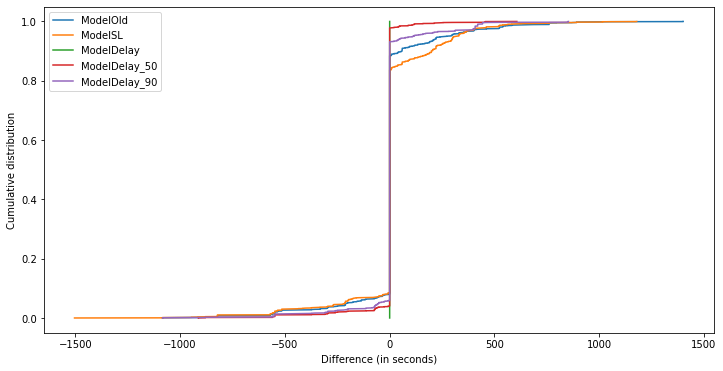

In [29]:
plt.figure(figsize=[12,6])
for model in models:
    df_comparison_temp = df_comparison_evaluation[(~df_comparison_evaluation["ModelDelay"].isnull())&(~df_comparison_evaluation[model].isnull())]
    plt.plot((df_comparison_temp[model]-df_comparison_temp["ModelDelay"]).dt.total_seconds().sort_values(),np.arange(len(df_comparison_temp))/(len(df_comparison_temp)), label=model)
plt.legend()
plt.xlabel("Difference (in seconds)")
plt.ylabel("Cumulative distribution")
plt.show()

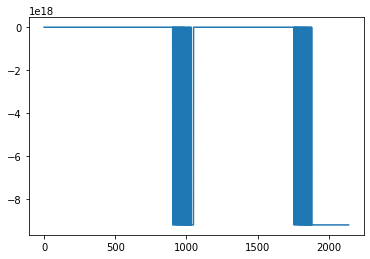

In [ ]:
plt.plot(df_comparison_evaluation["ModelDelay"]-df_comparison_evaluation["ModelDelay_50"])

In [ ]:
def get_arrival_list_itinerary(x: list[Itinerary_time]):
    if(len(x)>0):
        return x[0].arrival_times[-1]
    else:
        return pd.NaT

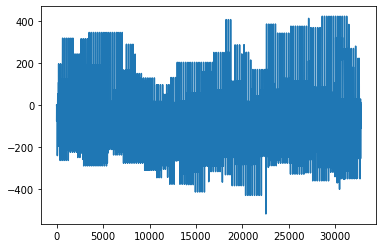

In [ ]:
plt.plot((df_raw_data["TimeTabledDateTime"]-df_raw_data["ExpectedDateTime"]).dt.total_seconds())

In [ ]:
proba =[]
for lis in df_comparison_concat["ModelDelay"]:
    if(len(lis)>0):
        proba.append(lis[0].probability)

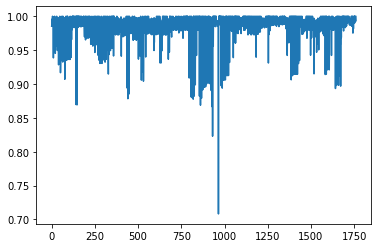

In [ ]:
plt.plot(proba)